# Introduction to Computer Simulation via SimPy

In this practical you will learn:

* How to use `numpy` for random sampling from statistical distributions
* How to create a `simpy` environment and create basic process models
* How to model resources and simulate queues
* How to collect results from a single run of the model

## Imports

It is recommended that you use the provided environment `hds_stoch`.  Please use simpy 4.0.x.  If you are running this notebook in Google colab then `simpy` can be installed by:

```python
!pip install simpy
```

In [1]:
import simpy
simpy.__version__

'4.0.1'

In [9]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

## Preliminaries 1: Random Sampling from Parametric Distributions in `numpy`

Before we progress to building `simpy` models we first need to explore how we can generate samples from well known statistical distributions in Python.  We will explore a range of statistical distributions in **input modelling**.  For now we will limit ourselves to some useful simple models.

In [57]:
def distribution_plot(samples, bins=100):
    hist = np.histogram(samples, bins=np.arange(bins), density=True)
    plt.plot(hist[0]);
    plt.ylabel('p(x)');
    plt.xlabel('x');
    

### The `numpy.random` namespace

Python provides several libraries for random sampling.  To begin with we will work with `numpy.random`.  This has the advantage of a very simple interface.  It is also possible to control psuedo random number streams using a seed on its own or paired with a `numpy.random.RandomState` object

### Simple and useful distributions

#### Exponential distribution

Useful for modelling the time between arrivals (Inter-Arrival Time; IAT). 

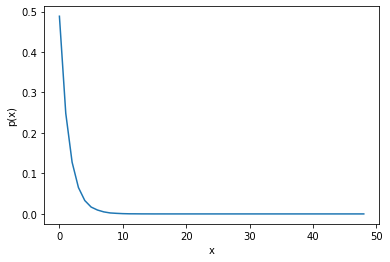

In [50]:
samples = np.random.exponential(scale=1.5, size=100000)
distribution_plot(samples, bins=50)

### Triangular distribution

Useful when not much is known about a distribution other than its likely range and the most common (mode) value.

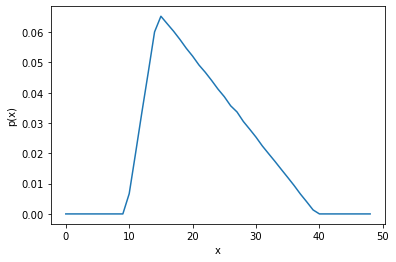

In [53]:
samples = np.random.triangular(left=10, mode=15, right=40, size=1000000)
distribution_plot(samples, bins=50)

#### Uniform distribution

Useful as an approximation when little is known, but a likely range of values

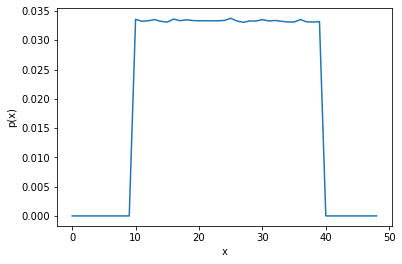

In [56]:
samples = np.random.uniform(low=10, high=40, size=1000000)
distribution_plot(samples, bins=50)

### Controlling random sampling using `np.random.seed`

We are modelling stochastic systems **BUT** our models should be controllable.  That means we should be able to rerun models and get the same results.  In simulation we do this by controlling the pseudo random number streams.

> In `numpy` one way to do this is setting a random seed.

```python
SEED = 42
np.random.seed(seed=SEED)
```
Let's create a random variable that is expontially distributed.  We will conduct two rounds of sampling. Each round will consist of two sample batches each containing 10 samples. In the first round, we will ignore the random seed.  In the second round we will set the random seed in between each the batches.


In [58]:
#round 1 => batch 1
np.random.exponential(scale=1.5, size=10)

array([0.92400813, 1.04129245, 1.76746893, 0.79769715, 1.23575877,
       1.28538774, 2.04850465, 0.38064992, 0.98474938, 0.24490686])

In [59]:
#round 1 => batch 2
np.random.exponential(scale=1.5, size=10)

array([2.61244026, 4.1010313 , 2.02623806, 0.05201321, 4.22619489,
       1.24408997, 0.00859406, 0.53018227, 0.21419029, 0.49322739])

You should notice that the random samples are different.  In fact, each time you run this you will get a different result. Not let's repeat that experiment, but this time set a random seed before each batch.

In [60]:
#round 2 => batch 1
np.random.seed(seed=42)
np.random.exponential(scale=1.5, size=10)

array([0.70390213, 4.51518215, 1.97511854, 1.36941383, 0.25443731,
       0.25439444, 0.08975815, 3.0168463 , 1.37862323, 1.84687509])

In [61]:
#round 2 => batch 2
np.random.seed(seed=42)
np.random.exponential(scale=1.5, size=10)

array([0.70390213, 4.51518215, 1.97511854, 1.36941383, 0.25443731,
       0.25439444, 0.08975815, 3.0168463 , 1.37862323, 1.84687509])

This time we get the same results.  Random sampling is not as random as it appears!  Always remember that simulation model is not a random game against nature.  It is a computer experiment.  **Hence it is controllable.**

### **Exercise 1**: controlled sampling from the uniform distribution

**Task:**

* Repeat the example given above, but this time use the uniform distribution.
* Use the random seed 101.  
* Try a few different seeds to check your code.
    

In [68]:
#your code here

### Complications: controlling sampling from multiple distributions

Consider a project where you are modelling a simple two stage patient pathway. 

* In the first stage of the pathway patients undergo a procedure that requires on average a 3 day spell in hospital. 
* In the second stage the patient undergos therapy at home.  On average a patient requires home therapy for 7 days.  
* A hospital is interested in what would happen to resource requirements if an intervention they have planned reduced demand on the service. 


Let's test out a simple model where we sample patients length of stay and home theory duration from two exponetial distributions.  We will use a random number seed and run two scenarios.  In the first scenario we will test sample 5 patients.  In the second we will sample 2.

In [98]:
def print_patient_details(acute, home):
    '''
    Helper function.
    Formats length of stay in data frame
    '''
    pd.set_option('precision', 2)
    df = pd.DataFrame(np.vstack([sample_acute, sample_home])).T
    df.columns = ['acute', 'home']
    return df

In [96]:
#first test - 5 patients included.
N_PATIENTS = 5
np.random.seed(42)
sample_acute = np.random.exponential(scale=3, size=N_PATIENTS)
sample_home = np.random.exponential(scale=7, size=N_PATIENTS)

print_patient_details(sample_acute, sample_home)

,acute,home
0,1.41,1.19
1,9.03,0.42
2,3.95,14.08
3,2.74,6.43
4,0.51,8.62


In [97]:
#second test - 2 patients included.
N_PATIENTS = 2
np.random.seed(42)
sample_acute = np.random.exponential(scale=3, size=N_PATIENTS)
sample_home = np.random.exponential(scale=7, size=N_PATIENTS)
print_patient_details(sample_acute, sample_home)

,acute,home
0,1.41,9.22
1,9.03,6.39


When the number of patients is reduced from 5 to 2 we get different sample values for the home therapy durations.  This is problematic because if we are not careful we may attribute improvements or lack of improvements between designs simply due to sampling variation.  

We are going to look at multiple ways to carefully analyse our model.  But for now it is useful to understand that we get this result because both distributions are using the same single stream of psuedo random numbers.  One way to solve this problem is therefore to give each distribution its **own stream**.

> In python we can do this using `numpy.random.RandomState`

In [104]:
#first retest - 5 patients included.
N_PATIENTS = 5

#create two random state objects
rs_acute = np.random.RandomState(seed=42)
rs_home = np.random.RandomState(seed=101)

sample_acute = rs_acute.exponential(scale=3, size=N_PATIENTS)
sample_home = rs_home.exponential(scale=7, size=N_PATIENTS)

print_patient_details(sample_acute, sample_home)

,acute,home
0,1.41,5.09
1,9.03,5.92
2,3.95,0.20
3,2.74,1.32
4,0.51,8.09


In [105]:
#second retest - 2 patients included.
N_PATIENTS = 2

#create two random state objects
rs_acute = np.random.RandomState(seed=42)
rs_home = np.random.RandomState(seed=101)

sample_acute = rs_acute.exponential(scale=3, size=N_PATIENTS)
sample_home = rs_home.exponential(scale=7, size=N_PATIENTS)

print_patient_details(sample_acute, sample_home)

,acute,home
0,1.41,5.09
1,9.03,5.92


Our second retest with a smaller group of patients now has the same acute and home sample values as the larger group.  We have successfully eliminated a some noise in our experiment and can more safely make statements about differences.  

> In general, it is recommended that models make use of `np.random.RandomState(seed)` over and above `np.random.seed(seed)`.  We will revisit this method later in the course and explore it in more detail.

### **Exercise 2**: controlled sampling from the uniform distribution using a RandomState object

**Task:**

* Repeat exercise 1, but make this time control sampling using a `np.random.RandomState` object.
* Use the random seed 101.  
* Try a few different seeds to check your code.

In [107]:
#your code here

### **Exercise 3**: add a third distribution to the treatment pathway example.

**Task:**

* Modify the code below to include a third random distribution and ensure that the same sample values are returned no matter how many patients are included.

In [ ]:
#first retest - 5 patients included.
N_PATIENTS = 5

rs_acute = np.random.RandomState(seed=42)
rs_home = np.random.RandomState(seed=101)

sample_acute = rs_acute.exponential(scale=3, size=N_PATIENTS)
sample_home = rs_home.exponential(scale=7, size=N_PATIENTS)
#sample_gp = #your code here

print_patient_details(sample_acute, sample_home)

## Basic `simpy` models

In this course we will make use of a **free and open source** discrete-event simulation python package called `simpy`.  

> An advantage of `simpy` over commerical simulation packages is its simplicity and flexibility.  As it is part of python, it is often straightforward to use `simpy` to model complex logic and make use of the SciPy stack!  Initially, you will need to write a lot of code. But don't worry. During the course we will build a up our own library of reusable code that we can draw on (and build on) for future simulation projects.  As `simpy` is free and open it has a big advantage over commerical software for both research and health system use.  



### A first example: a hospital pharmacy

In this first example, let's assume (unrealistically) that prescriptions arrive **exactly** 5 minutes apart.  To build this model we need the following components:

#### **A simpy environment**

`simpy` has process based worldview.  These processes take place in an environment.  You can create a environment with the followinug line of code:

```python
env = simpy.Environment()
```

#### **simpy timeouts**

We can introduce **delays** or **activities** into a process.  For example these might be the duration of a stay on a ward, or the duration of a operation.  In this case we are going to introduce a delay between arrivals (inter-arrival time).  In `simpy` you control this with the following method:

```python
activity_duration = 20
env.timeout(activity_duration)
```

#### **generators**

The event process mechanism in `simpy` is implemented using python generators.  A basic generator function that yields a new arrival every 5 minutes looks like this:

```python
def prescription_arrival_generator(env):
    while True:
        yield env.timeout(5.0)
```

Notice that the generator takes the environment as a parameter.  It then internally calls the `env.timeout()` method in an infinite loop.

#### **running a `simpy` model**

Once we have coded the model logic and created an environment instance, there are two remaining instructions we need to code.

1. set the generator up as a simpy process

```python
env.process(prescription_arrival_generator(env))
```

2. run the environment for a user specified run length

```python
env.run(until=25)
```

The run method handle the infinite loop we set up in `prescription_arrival_generator`. The simulation model has an internal concept of time.  It will end execution when its internal clock reaches 25 time units.

**Now that we have covered the basic building blocks, let's code the actual model.**  It makes sense to create our model logic first.  The code below will generate arrivals every 5 minutes.  Note that the function takes an environment object as a parameter.

In [127]:
def prescription_arrival_generator(env):
    '''
    Prescriptions arrive with a fixed duration of
    5 minutes.
    
    Parameters:
    ------
    env: simpy.Environment
    '''
    while True:
        inter_arrival_time = 5.0
        yield env.timeout(inter_arrival_time)
        print(f'Prescription arrives at: {env.now}')

Now that we have our generator function we can setup the environment, process and call run.  We will create a `RUN_LENGTH` parameter that you can change to run the model for different time lengths.  What would happen if this was set to 50?

In [138]:
#model parameters
RUN_LENGTH = 25

env = simpy.Environment()
env.process(prescription_arrival_generator(env))
env.run(until=RUN_LENGTH)
print(f'end of run. simulation clock time = {env.now}')

Prescription arrives at: 5.0
Prescription arrives at: 10.0
Prescription arrives at: 15.0
Prescription arrives at: 20.0
end of run. simulation clock time = 25


### **Exercise 3**: modelling a poisson arrival process for prescriptions

**Task:**

* Update `prescription_arrival_generator()` so that inter-arrival times follow an exponential distribution with a mean of 5.0 minutes between arrivals.
* Use a run length of 25 minutes.

> **Bonus**: try this initially **without** setting a random seed.  Then update the method choosing an approach to control random sampling.


In [ ]:
#your code goes here

In [155]:
#example answer
def prescription_arrival_generator(env, random_state=None):
    '''
    Prescriptions arrive with a fixed duration of
    5 minutes.
    
    Parameters:
    ------
    env: simpy.Environment
    
    random_state: int, optional (default=None)
        if set then used as random seed to control sampling.
    '''
    rs_arrivals = np.random.RandomState(random_state)
    
    while True:
        inter_arrival_time = rs_arrivals.exponential(5.0)
        yield env.timeout(inter_arrival_time)
        print(f'Prescription arrives at: {env.now}')

In [160]:
#model parameters
RUN_LENGTH = 25
SEED = 101

env = simpy.Environment()
env.process(prescription_arrival_generator(env, random_state=SEED))
env.run(until=RUN_LENGTH)
print(f'end of run. simulation clock time = {env.now}')

Prescription arrives at: 3.6324716128740935
Prescription arrives at: 7.86009063444738
Prescription arrives at: 8.004528038950323
Prescription arrives at: 8.945350946619923
Prescription arrives at: 14.725662616366167
Prescription arrives at: 23.70139448705195
end of run. simulation clock time = 25


In [ ]:
### Adding prescription preparation and queuing



In [144]:
class Prescription(object):
    def __init__(self, env, operations_dist, pharmacists):
        self.env = env
        self.dist = operations_dist
        self.pharmacists = pharmacists
        
    def process_prescription(self):
        
        while True:
            
        

SyntaxError: unexpected EOF while parsing (<ipython-input-144-a89380050757>, line 11)